## 이 노드의 루브릭       
---

1. CAM을 얻기 위한 기본 모델의 구성과 학습이 정상 진행되었는가?      
    : ResNet50 + GAP + DenseLayer가 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
    
    
2. 분류 근거를 설명 가능한 Class Activation Map을 만들 수 있는가?       
    : CAM 방식과 Grad-Cam 방식의 Class Activation map이 정상적으로 얻어졌다.
    : 시각화 하였을 때 해당 object의 주요 특징 위치를 잘 반영하였다.          
    
    
3. 인식 결과의 시각화 및 성능 분석을 적절히 수행하였는가?           
    : CAM과 Grad-CAM 각각에 대한 원본 이미지 합성, 바운딩 박스, IoU 계산 과정을 통해         
    CAM과 Grad-CAM의 object Localization 성능이 비교 분석되었다.

## 목차               
---

1. CAM과 Grad-CAM 구현을 위한 제반환경 setup                
    A. 데이터 준비하기            
    B. 모델 만들기         
    C. 모델 학습시키기               
   
   
2. CAM 만들기          


3. Grad-CAM 만들기


4. Detection with CAM           


5. CAM과 Grad-Cam의 성능 비교            
    A. CAM, Grad-Cam 과 원본 이미지 합성하기                  
    B. 바운딩 박스 추측하기            
    C. IoU 계산하기                          
    
    
6. 결론

## 1.CAM과 Grad-CAM 구현을 위한 제반환경 setup
---
### A. 데이터 준비하기

- Tensorflow Dataset의 Cars196 데이터셋을 사용          
- 분류 문제를 해결하는 데이터셋이므로, CAM과 Grad-CAM(이 경우 모델 구조에 제약이 없으므로 CAM 모델을 재활용)의 적용에 문제 없을 것으로 판단한다.

In [1]:
#라이브러리 임포트
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('필요한 라이브러리 임포트')

필요한 라이브러리 임포트


In [2]:
#GPU 사용가능여부 체크
tf.config.list_physical_devices('GPU')

[]

In [8]:
tfds.__version__

'4.2.0'

In [3]:
#데이터셋 다운로드
#데이터셋 로드에 문제가 있어 로컬 다운로드 파일로 로드하였다.
import os
import glob

train_path = os.getenv('HOME')+'/GoingDeep/10_CAM/cars_train/*.jpg'
test_path = os.getenv('HOME')+'/GoingDeep/10_CAM/cars_test/*.jpg'

In [4]:
#train_data 폴더에 있는 모든 요소들을 불러들여 저장한다.
train_list = glob.glob(train_path)

In [57]:
train_data = []

for files in train_list:
    image = cv2.imread(files)
    train_data.append(image)

In [58]:
print('train_data의 수 :' , len(train_data))

train_data의 수 : 8144


> - 8,144개의 데이터셋이 모두 잘 들어와있음을 확인할 수 있다.

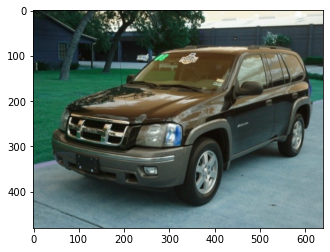

In [60]:
plt.imshow(train_data[1])

In [7]:
#test도 동일하게 처리한다.
# test_list = glob.glob(test_path)

In [ ]:
#왜 자꾸 얘만 시행하면 죽을까
# test_data = []

# for files in test_list:
#     image = cv2.imread(files)
#     test_data.append(image)

In [18]:
#feature 특징은 다른 곳에서 가져와야 한다.
#.mat이므로 matplotlib 파일임을 알 수 있다.
ds_info_path = os.getenv('HOME') + '/GoingDeep/10_CAM/devkit/cars_train_annos.mat'

In [20]:
from scipy import io

ds_info = []

ds_info = io.loadmat(ds_info_path)

In [25]:
ds_info['annotations']

array([[(array([[39]], dtype=uint8), array([[116]], dtype=uint8), array([[569]], dtype=uint16), array([[375]], dtype=uint16), array([[14]], dtype=uint8), array(['00001.jpg'], dtype='<U9')),
        (array([[36]], dtype=uint8), array([[116]], dtype=uint8), array([[868]], dtype=uint16), array([[587]], dtype=uint16), array([[3]], dtype=uint8), array(['00002.jpg'], dtype='<U9')),
        (array([[85]], dtype=uint8), array([[109]], dtype=uint8), array([[601]], dtype=uint16), array([[381]], dtype=uint16), array([[91]], dtype=uint8), array(['00003.jpg'], dtype='<U9')),
        ...,
        (array([[26]], dtype=uint8), array([[246]], dtype=uint8), array([[660]], dtype=uint16), array([[449]], dtype=uint16), array([[163]], dtype=uint8), array(['08142.jpg'], dtype='<U9')),
        (array([[78]], dtype=uint8), array([[526]], dtype=uint16), array([[1489]], dtype=uint16), array([[908]], dtype=uint16), array([[112]], dtype=uint8), array(['08143.jpg'], dtype='<U9')),
        (array([[20]], dtype=uint8

## B. 모델 만들기       
---

In [30]:
#num_classes = ds_info.features["labels"].num_classes
#일단 임시값을 넣어주자
num_classes = 10

#include_top=False로 FCN을 제거
#pooling='avg'하여 gap가 적용되도록 조정
base_model = keras.applications.resnet.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3),
                                                pooling='avg')

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [31]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

> - 여기서 feature map을 찾는다면, 마지막 avg_pool이 적용되기 직전의 conv5_block3_out 이다.

#### 학습을 위한 준비

- 모델에 이미지를 투입하기 위해, 노말라이제이션과 리사이징 전처리를 수행한다.    
- 전체 데이터셋에 nomalization + resize를 수행하는 작업을 한다.

In [ ]:
#원래라면 이 함수를 썼겠지만.. 지금은 분리가 된 것이에요...
# def normalization_and_resizing(input):
#     image = tf.image.resize(input['image'], [224, 224])
#     input['image'] = tf.cast(image, tf.float32)/225.
    
#     return input['image'], input['label']

In [76]:
#cv2의 힘을 빌렸다.
def normalization_and_resize(images):
    images = cv2.resize(images, dsize=(224,224))
    images = cv2.normalize(images, images, 0, 255, cv2.NORM_MINMAX)
    return images

#### 전처리 함수 테스트

In [62]:
#테스트해보자.
train_data[1].shape

(480, 640, 3)

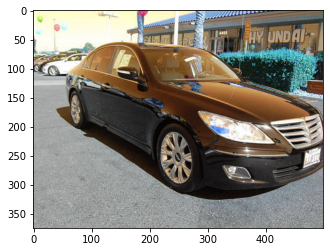

In [77]:
test_image = train_data[2].copy()

plt.imshow(test_image)

In [78]:
test_image = normalization_and_resize(test_image)

바뀐 이미지 크기 :  (224, 224, 3)


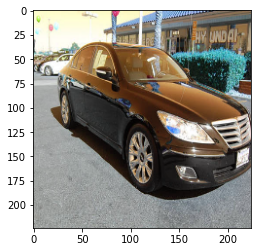

In [79]:
print('바뀐 이미지 크기 : ', test_image.shape)

plt.imshow(test_image)

> 인풋한 이미지의 shape이 바뀌었음을 알 수 있다.

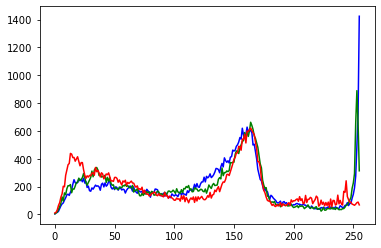

In [83]:
#내친김에 히스토그램도 확인해보지 뭐

channels = cv2.split(test_image)
colors = ('b', 'g', 'r')

for (ch, co) in zip(channels, colors):
    hist = cv2.calcHist([ch], [0], None, [256], [0,256])
    plt.plot(hist, color=co)
    
plt.show()

> - 0~255 값으로 노말라이제이션한 값이 대충 위와 같이 분포함을 알 수 있다.

In [84]:
#이제 진짜진짜 전처리 함수!
def apply_normalization_on_dataset(dataset, is_test=False, batch_size=16):
    
    dataset = dataset.map(normalization_and_resize, num_parallel_calls=2)
    dataset = dataset.batch(batch_size)
    
    #학습데이터일 경우
    if not is_test:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(200)
        
    
    #공통적용
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [85]:
train_dataset = apply_normalization_on_dataset(train_data)

AttributeError: 'list' object has no attribute 'map'

In [ ]:
#전처리 완료된 데이터를 확인
for input in train_dataset.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

### C. 모델 학습시키기

In [ ]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
#학습한 가중치는 저장

In [ ]:
cam_model_path = os.getenv('HOME')+'/GoingDeep/10_CAM/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")